In [1]:
import sys
sys.path.append('..')

In [3]:
import tensorflow as tf
from tensorflow import keras

import config
from losses import MSE
from models import unet

from utils import (
    notebook_select_gpu,
    load_depth_data,
    load_apollo_data,
    get_normalized_ds,
    visualize_depth_map,
    plot_loss,
)

notebook_select_gpu(0)

## Train model

In [5]:
(x_train, y_train), (x_test, y_test) = load_depth_data()

ds_train = get_normalized_ds(x_train[: config.N_TRAIN], y_train[: config.N_TRAIN])
ds_test = get_normalized_ds(x_test[: config.N_TEST], y_test[: config.N_TEST])

_, (x_ood, y_ood) = load_apollo_data()
ds_ood = get_normalized_ds(x_ood, y_ood)

2022-12-08 17:32:26.193213: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.
2022-12-08 17:32:26.570941: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 167772160 exceeds 10% of free system memory.
2022-12-08 17:32:26.648550: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.
2022-12-08 17:32:26.797656: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 167772160 exceeds 10% of free system memory.
2022-12-08 17:32:26.966416: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


In [7]:
model_name = "base"

base_model = unet()
base_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.LR),
    loss=MSE,
)

In [8]:
history = base_model.fit(
    ds_train,
    epochs=config.EP,
    validation_data=ds_test,
)

2022-12-08 08:40:46.614993: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.


Epoch 1/20


2022-12-08 08:40:48.042004: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-08 08:40:48.042735: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


64/64 [==============================] - 10s 124ms/step - loss: 0.1252 - val_loss: 0.0575
Epoch 2/20
64/64 [==============================] - 8s 121ms/step - loss: 0.0468 - val_loss: 0.0353
Epoch 3/20
64/64 [==============================] - 8s 121ms/step - loss: 0.0304 - val_loss: 0.0265
Epoch 4/20
64/64 [==============================] - 8s 121ms/step - loss: 0.0238 - val_loss: 0.0154
Epoch 5/20
64/64 [==============================] - 8s 122ms/step - loss: 0.0152 - val_loss: 0.0114
Epoch 6/20
64/64 [==============================] - 8s 121ms/step - loss: 0.0116 - val_loss: 0.0094
Epoch 7/20
64/64 [==============================] - 8s 122ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 8/20
64/64 [==============================] - 8s 122ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 9/20
64/64 [==============================] - 8s 121ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 10/20
64/64 [==============================] - 8s 122ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 11/

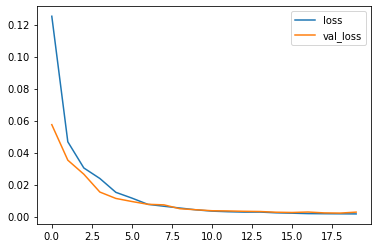

In [9]:
plot_loss(history)

/home/iaroslavelistratov/depth/capsa/experiments/notebooks/../utils.py:61: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color="black")


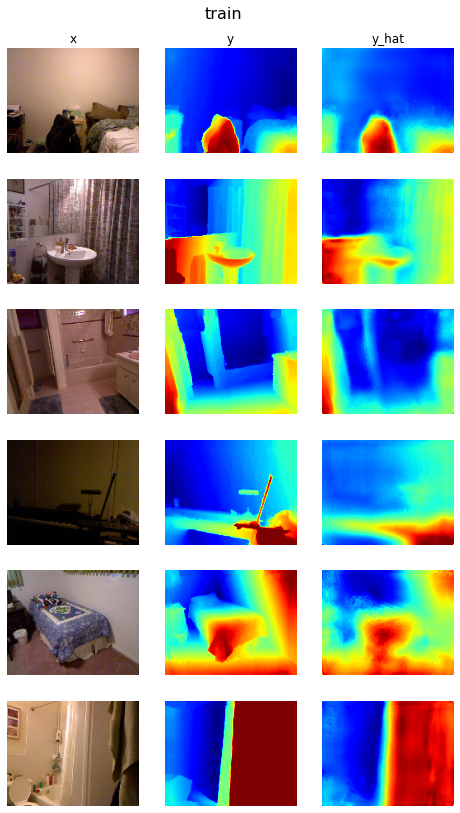

In [10]:
visualize_depth_map(base_model, ds_train, "train", plot_risk=False)

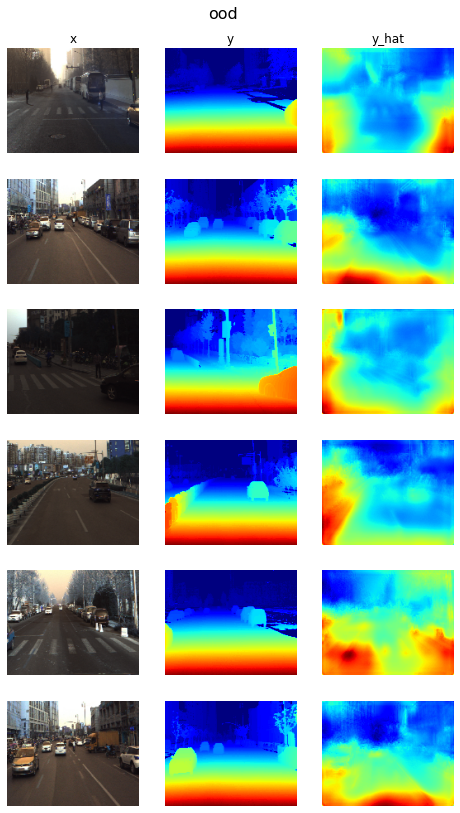

In [11]:
visualize_depth_map(base_model, ds_ood, "ood",  plot_risk=False)

## Load trained model

In [6]:
from utils import load_model, select_best_checkpoint

path, model_name = select_best_checkpoint('/home/iaroslavelistratov/results/base/20221208-180920')
trained_model = load_model(path, model_name, ds_train, quite=False)

2022-12-08 17:32:32.313191: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-08 17:32:32.313721: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-12-08 17:32:40.759979: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/iaroslavelistratov/results/base/20221208-180920/checkpoints/0.002792vloss_41446iter.tf: FAILED_PRECONDITION: /home/iaroslavelistratov/results/base/20221208-180920/checkpoints/0.002792vloss_41446iter.tf; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Successfully loaded weights from /home/iaroslavelistratov/results/base/20221208-180920/checkpoints/0.002792vloss_41446iter.tf.


/home/iaroslavelistratov/depth/capsa/experiments/notebooks/../utils.py:61: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color="black")


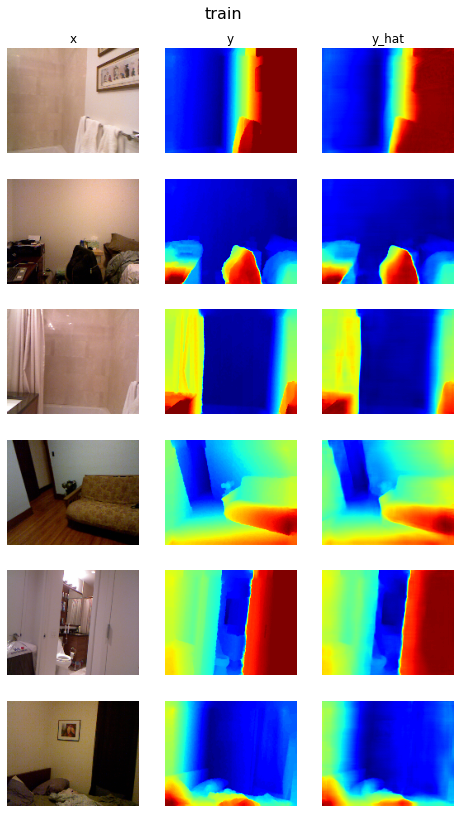

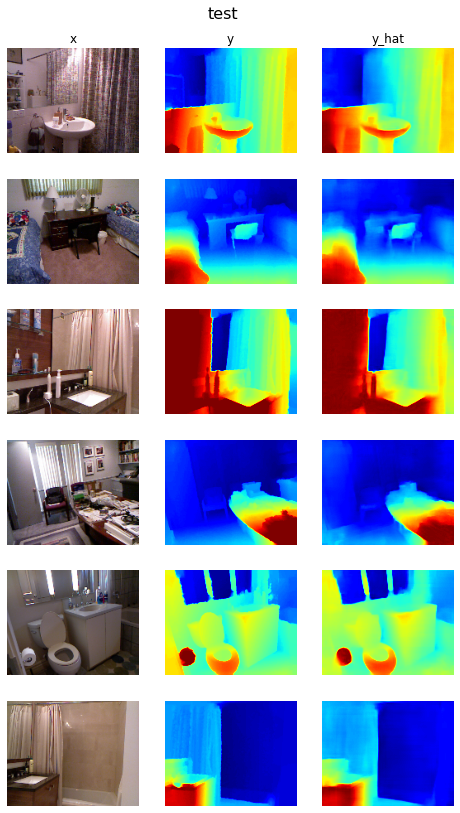

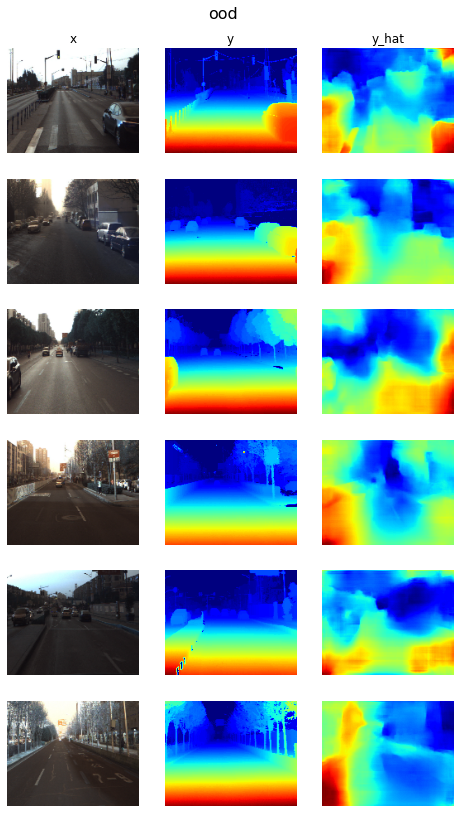

In [7]:
visualize_depth_map(trained_model, ds_train, 'train', plot_risk=False)
visualize_depth_map(trained_model, ds_test, 'test', plot_risk=False)
visualize_depth_map(trained_model, ds_ood, 'ood', plot_risk=False)